## This file is used to get forecasting data and error

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import math
from math import sqrt
import re
from datetime import datetime
import datetime
from sklearn import preprocessing
import sys
import time

In [344]:
hist_data = pd.read_csv("data/power_data_15minutes.csv")

In [345]:
hist_data.Date = pd.to_datetime(hist_data.Date)

In [346]:
season = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer', 7:'Summer',\
         8:'Summer', 9:'Fall', 10:'Fall', 11:'Fall', 12:'Winter'}

#normalization
Cha = ['TMP','WNDCHILL','WNDSPD','Humidity','PRMSL','RAIN']
min_max_scaler = preprocessing.MinMaxScaler()
hist_data[Cha] = min_max_scaler.fit_transform(hist_data[Cha]) 

In [347]:
#target_date info.
target_year = 2020  
target_month = 5
target_day = 1

In [348]:
target_season = season[target_month]

target_date = datetime.date(target_year, target_month, target_day)
if (target_date.weekday() + 1) < 6:
    target_weekday = 1
else:
    target_weekday = 0 


In [349]:
tar_weather = pd.read_csv("data/target_day_weather.csv", sep=',', header = None, index_col=0)\
.T

In [350]:
# get omega_A
omega_A = hist_data[(hist_data.Season == target_season) & (hist_data.weekday == target_weekday)]

In [351]:
omega_A['Hour'] = omega_A.Date.dt.hour
omega_A['Day'] = omega_A.Date.dt.date

In [352]:
omega_A = omega_A.drop_duplicates(subset=['Day', 'Hour'], keep='first', inplace=False)

In [353]:
def get_omega_B(omega_A):
    time_lst = list(omega_A.Day.unique())
    selected = list(time_lst)[-10:]
    return selected

In [354]:
omega_B = get_omega_B(omega_A)

In [355]:
omega_B

[datetime.date(2019, 5, 31),
 datetime.date(2020, 3, 2),
 datetime.date(2020, 3, 3),
 datetime.date(2020, 3, 4),
 datetime.date(2020, 3, 5),
 datetime.date(2020, 3, 6),
 datetime.date(2020, 3, 9),
 datetime.date(2020, 3, 10),
 datetime.date(2020, 3, 11),
 datetime.date(2020, 3, 12)]

In [356]:
def weather_distance(X, target):
    time_series = pd.Series([0,2,4,6,8,10,12,14,16,18,20,22])
    
    del_T = time_series.apply(lambda x: abs(target[target.Hour == x].Temperature.values \
                              - X[(X.Hour == x)].TMP.values)[0])
    
    del_W = time_series.apply(lambda x: abs(target[target.Hour == x].Wind.values \
                              - X[(X.Hour == x)].WNDSPD.values)[0])
    
    del_H = time_series.apply(lambda x: abs(target[target.Hour == x].Humidity.values \
                              -  X[(X.Hour == x)].Humidity.values)[0])
    
    del_P = time_series.apply(lambda x: abs(target[target.Hour == x].Pressure.values \
                              - X[(X.Hour == x)].PRMSL.values)[0])
    
    del_R = time_series.apply(lambda x: abs(target[target.Hour == x].Rain.values \
                              - X[(X.Hour == x)].RAIN.values)[0])
    
    return [del_T[del_T.notnull()].mean(), del_W[del_W.notnull()].mean(), del_H[del_H.notnull()].mean(), \
           del_P[del_P.notnull()].mean(), del_R[del_R.notnull()].mean()]

In [357]:
del_matrix = list()
for i in omega_B:  
    del_matrix.append(weather_distance(omega_A[omega_A.Day == i], tar_weather)) #got weather distance of Omega_B's data

In [358]:
min_max_scaler = preprocessing.MinMaxScaler()
nor_mat = min_max_scaler.fit_transform(pd.DataFrame(del_matrix)).sum(axis = 1) #normalize the distance

In [359]:
weather_dic = dict(zip(omega_B, nor_mat))
sorted_wea_dis = sorted(weather_dic.items(), key=lambda d: d[1])

In [360]:
omega_C = [x[0] for x in sorted_wea_dis[:5]]

In [361]:
omega_C

[datetime.date(2020, 3, 6),
 datetime.date(2020, 3, 3),
 datetime.date(2020, 3, 12),
 datetime.date(2020, 3, 9),
 datetime.date(2020, 3, 4)]

#### average sampled data to get demand file   and get error matrix

In [362]:
sampled_data = hist_data[hist_data.Date.dt.date.isin(omega_C)]

In [363]:
len(sampled_data) #120[hours] = 5[days] * 24[hours/day] * 4[timesteps/hour]

480

In [364]:
sampled_data = sampled_data.reset_index(drop = True)

In [365]:
hour_lst = pd.Series(range(96))
Demand_pred = hour_lst.apply(lambda x: sampled_data\
                             [(sampled_data.Date.dt.minute/15 + sampled_data.Date.dt.hour * 4) == x]\
                             .Power.mean()/1000)

Text(0.5, 0, 'Time [h]')

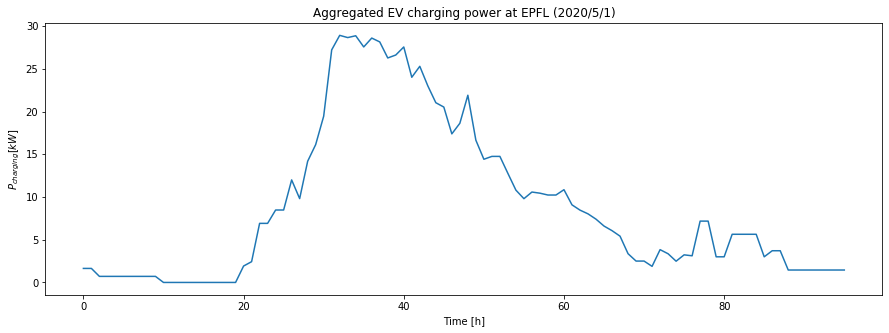

In [366]:
plt.figure(figsize=(15,5))
plt.plot(Demand_pred)
plt.title('Aggregated EV charging power at EPFL (%d/%d/%d)'%(target_year,target_month,target_day))
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

In [367]:
Err = list()
for i in omega_C:
    Err.append(sampled_data[sampled_data.Date.dt.date == i]\
                    .Power.reset_index(drop = True)/1000 - Demand_pred)
    

In [368]:
Demand_pred = pd.DataFrame(Demand_pred)

In [369]:
Demand_pred.columns = ['Power']

In [370]:
Error = pd.DataFrame(Err).T

In [371]:
Error.columns = omega_C

In [372]:
Demand_pred.to_excel('data/demand_pred.xlsx',index = True, header = True)

In [373]:
Error.to_excel('data/Error.xlsx',index = True, header = True)